# Question V

In [129]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [130]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

    return call_price

## 1. Discrétiser l’EDS de Black & Scholes avec un schéma d’Euler et un schéma de Milstein. Illustrer les convergences et retrouver les ordres forts et faibles de chacun des schémas.

In [131]:
def simulate_paths(N, dt, X_0, r, sigma):
    X_euler = np.zeros(N+1)
    X_milstein = np.zeros(N+1)
    X_bs = np.zeros(N+1)
    X_euler[0] = X_0
    X_milstein[0] = X_0
    X_bs[0] = X_0
    
    # Fonctions de l'EDS de BS
    a = lambda x : r * x
    b = lambda x : sigma * x

    for i in range(1, N+1):
        Z = np.random.normal()

        # Euler method
        X_euler[i] = X_euler[i-1] + a(X_euler[i-1]) * dt + b(X_euler[i-1]) * np.sqrt(dt) * Z

        # Milstein method
        X_milstein[i] = X_milstein[i-1] + a(X_milstein[i-1]) * dt \
                        + b(X_milstein[i-1]) * np.sqrt(dt) * Z \
                        + 0.5 * b(X_milstein[i-1]) * sigma * dt * ( np.square(Z) - 1)


        X_bs[i] = X_bs[i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return X_euler, X_milstein, X_bs

We will perform simulation of each model, and compare their values to the theoretical model. In this section, we will search for the strong error, that is:

\begin{equation}
    E [\sup_{j=1,\dots,M} |\hat{X_{jh}} - X_{jh}|]
\end{equation}

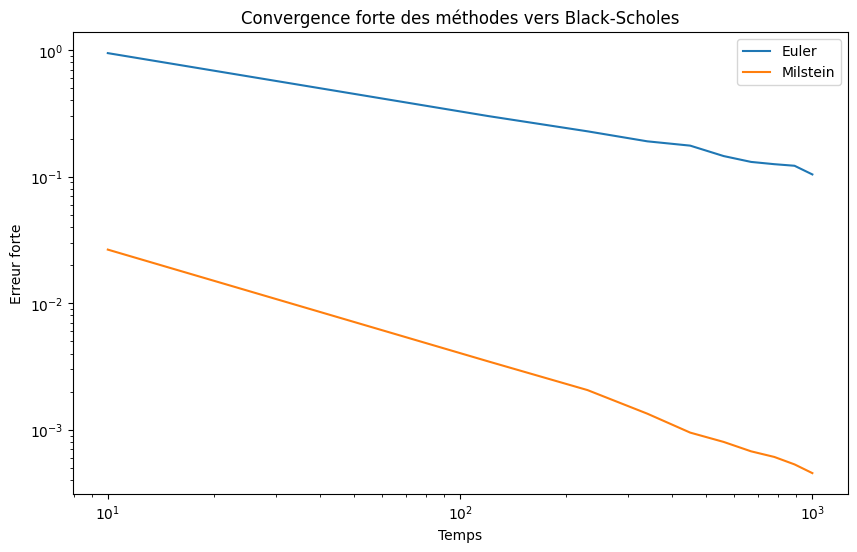

In [132]:
np.random.seed(42)

r = 0.01
sigma = 0.2
X_0 = 100
T = 1.0

N = 1000
dt = T/N

num_paths = 100
num_steps_values = np.linspace(10, 1000, 10)

plt.figure(figsize=(10, 6))

strong_error_euler = np.zeros(len(num_steps_values))
strong_euler_milstein = np.zeros(len(num_steps_values))

for i, num_steps in enumerate(num_steps_values):
  dt = T / int(num_steps)
  for j in range(num_paths):
      X_euler, X_milstein, X_bs = simulate_paths(int(num_steps), dt, X_0, r, sigma)

      strong_error_euler[i] += np.max(np.abs(X_euler-X_bs))
      strong_euler_milstein[i] += np.max(np.abs(X_milstein-X_bs))

  strong_error_euler[i] /= num_paths
  strong_euler_milstein[i] /= num_paths

plt.plot(num_steps_values, strong_error_euler, label=f'Euler')
plt.plot(num_steps_values, strong_euler_milstein, label=f'Milstein')

plt.title('Convergence forte des méthodes vers Black-Scholes')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Temps')
plt.ylabel('Erreur forte')
plt.legend()
plt.show()

To obtain this simulation, we did the discretisation of euler and milstein discretisation. We also did, for the same random values obtain for each step, obtained the simulation of the black-scholes model using a step by step approach of the solution, that is: 

\begin{equation}
    S_{i h} = S_{(i-1)h} \exp^{ ( r - \frac{1}{2} \sigma^2) h + \sigma \sqrt{h} B_{i h}  }
\end{equation}

We can see that the model of milstein has a lower strong error, but more importantly, a stronger convergence order. This is correct according to the theory.


In [133]:
def fit_line(x, y):
    coeffs = np.polyfit(np.log(x), np.log(y), 1)
    return coeffs[0]

order_euler = fit_line(num_steps_values, strong_error_euler)
order_milstein = fit_line(num_steps_values, strong_euler_milstein)

print(f"Ordre de convergence pratique pour Euler : {-order_euler}")
print(f"Ordre de convergence théorique pour Euler : 0.5")
print(f"Ordre de convergence pratique pour Milstein : {-order_milstein}")
print(f"Ordre de convergence théorique pour Milstein : 1")

Ordre de convergence pratique pour Euler : 0.4673773486764612
Ordre de convergence théorique pour Euler : 0.5
Ordre de convergence pratique pour Milstein : 0.8844110470820564
Ordre de convergence théorique pour Milstein : 1


We can see that the order of convergence is highly close to their respective theoretical value, proving that the code is working correctly.

Now we will study the weak error of the models. We understand as weak errors as:

\begin{equation}
    | E [ f ( \hat{X_T} ) ] - E [ f(X_T) ] |
\end{equation}

where f is regular enough.

We can this function to be $f(x) = x$

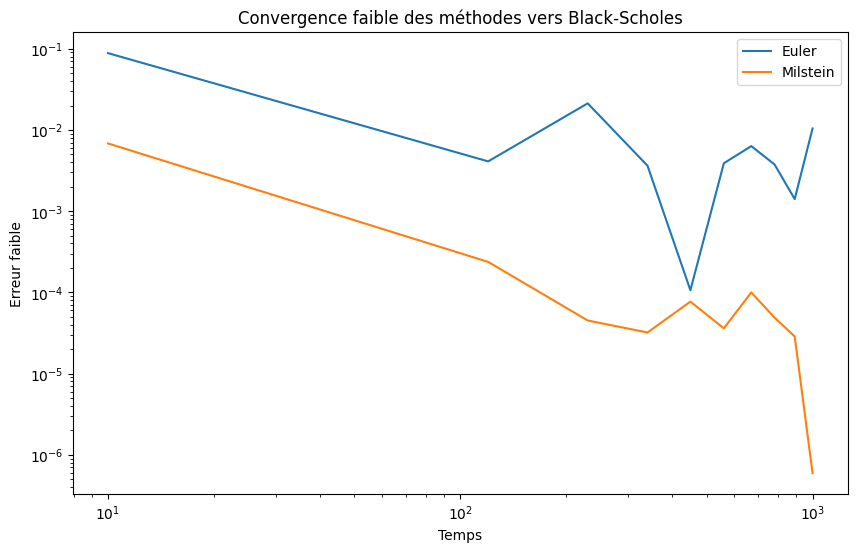

In [134]:
np.random.seed(42)

r = 0.01
sigma = 0.2
X_0 = 100
T = 1.0

N = 1000
dt = T/N

num_paths = 100
num_steps_values = np.linspace(10, 1000, 10)

f = lambda x: x  # definit fonction convergence faible

plt.figure(figsize=(10, 6))

weak_error_euler = np.zeros(len(num_steps_values))
weak_euler_milstein = np.zeros(len(num_steps_values))

euler_f = np.zeros(len(num_steps_values))
milstein_f = np.zeros(len(num_steps_values))
bs_f = np.zeros(len(num_steps_values))

for i, num_steps in enumerate(num_steps_values):
  num_steps=int(num_steps)
  euler_f = 0
  milstein_f = 0
  bs_f = 0
  for j in range(num_paths):
      dt = T / num_steps
      X_euler, X_milstein, X_bs = simulate_paths(num_steps, dt, X_0, r, sigma)

      euler_f += f(X_euler[-1])
      milstein_f += f(X_milstein[-1])
      bs_f += f(X_bs[-1])

  euler_f /= num_paths
  milstein_f /= num_paths
  bs_f /= num_paths

  weak_error_euler[i] += np.abs(euler_f-bs_f)
  weak_euler_milstein[i] += np.abs(milstein_f-bs_f)

plt.plot(num_steps_values, weak_error_euler, label=f'Euler')
plt.plot(num_steps_values, weak_euler_milstein, label=f'Milstein')

plt.title('Convergence faible des méthodes vers Black-Scholes')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Temps')
plt.ylabel('Erreur faible')
plt.legend()
plt.show()

Again, we performed simulation and then we compared to the theoretical value. Both methods are converging with a relatively similar order.

However, it is important to notice that the Milstein starts with a lower error, giving a better overall performance than the euler method.

However, we can notice a particular phenomenom. From a certain small step taken by the algorithm, the error stops having a stable behaviour. Instead, it becomes very erratical. This is due to error progragation. Since each step is calculated from the previous step, the error from each moment is propagated and multiplicated by each step. This phenomen is stronger in our theoretical black scholes numerical implementation, since it works with exponential values.

In [135]:
order_euler = fit_line(num_steps_values, weak_error_euler)
order_milstein = fit_line(num_steps_values, weak_euler_milstein)

print(f"Ordre de convergence pratique pour Euler : {-order_euler}")
print(f"Ordre de convergence théorique pour Euler : 1")
print(f"Ordre de convergence pratique pour Milstein : {-order_milstein}")
print(f"Ordre de convergence théorique pour Milstein : 1")

Ordre de convergence pratique pour Euler : 0.712112798344792
Ordre de convergence théorique pour Euler : 1
Ordre de convergence pratique pour Milstein : 1.3790027973253975
Ordre de convergence théorique pour Milstein : 1


Nous retrouvons bien les ordres de convergence attendus.

Now we will see how the returns behave.

Text(0.5, 1.0, 'Simulation  returns over time of bs model')

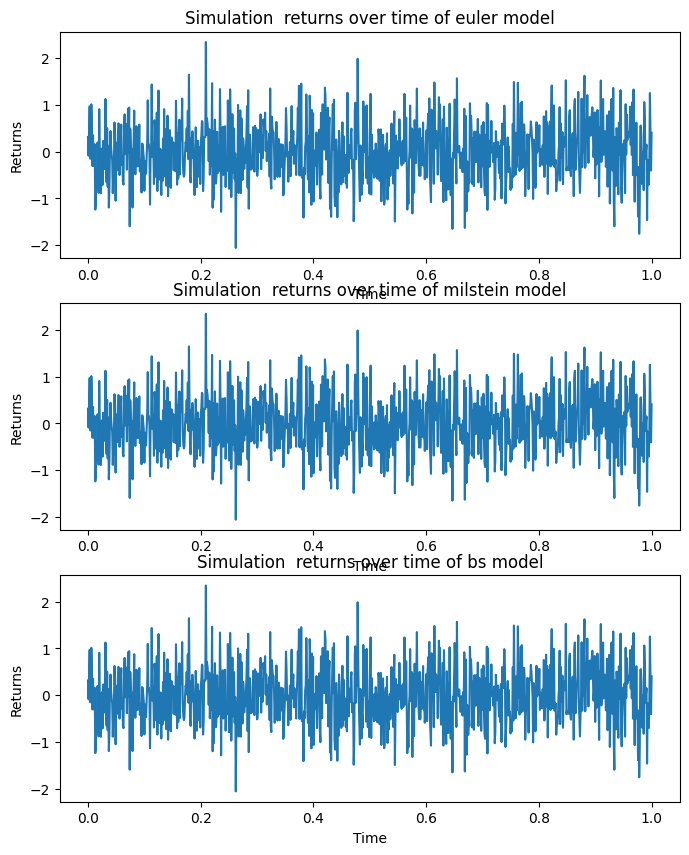

In [136]:
np.random.seed(42)

r = 0.01
sigma = 0.2
X_0 = 100
T = 1.0

N = 1000
dt = T/N

num_steps = 1000

X_euler, X_milstein, X_bs = simulate_paths(num_steps, dt, X_0, r, sigma)

f_returns = lambda x : x[1:] - x[:-1]
euler_returns = f_returns(X_euler)
milstein_returns = f_returns(X_milstein)
bs_returns = f_returns(X_bs)

X_range = np.linspace(0, 1, num_steps)

plt.figure(figsize=(8, 10))
plt.subplot(3, 1, 1)
plt.plot(X_range, euler_returns) 
plt.ylabel("Returns")
plt.xlabel("Time")
plt.title(f"Simulation  returns over time of euler model")

plt.subplot(3, 1, 2)
plt.plot(X_range, euler_returns) 
plt.ylabel("Returns")
plt.xlabel("Time")
plt.title(f"Simulation  returns over time of milstein model")

plt.subplot(3, 1, 3)
plt.plot(X_range, euler_returns) 
plt.ylabel("Returns")
plt.xlabel("Time")
plt.title(f"Simulation  returns over time of bs model")


# 2. Implémenter le pricing d’un call standard dans le modèle de Heston par Monte Carlo, avec le schéma d’Euler simple proposé.

In [137]:
def heston_simulation(S0, T, r, v0, lambd, v_, eta, rho, N, I):
    dt = T / N
    np.random.seed(0)

    X = np.zeros((N + 1, I))
    X[0] = np.log(S0)
    v = np.zeros_like(X)
    v[0] = v0

    for t in range(1, N + 1):
        b1 = np.random.standard_normal(I)
        b2 = np.random.standard_normal(I)
        dz1 = b1 * np.sqrt(dt)
        dz2 = (rho * b1 + np.sqrt(1 - rho ** 2) * b2) * np.sqrt(dt)

        # conditions réfléchissantes
        v[t] = np.maximum(v[t - 1] - lambd * (np.maximum(v[t - 1], 0) - v_) * dt + eta * np.sqrt(np.maximum(v[t - 1], 0)) * dz2, 0)
        X[t] = X[t - 1] + (r - 0.5 * v[t - 1]) * dt + np.sqrt(v[t - 1]) * dz1
    return np.exp(X)



def heston_call(S0, K, T, r, v0, lambd, v_, eta, rho, N, I, IC=False):
    
    S = heston_simulation(S0, T, r, v0, lambd, v_, eta, rho, N, I)   
    C0 = np.exp(-r * T) * np.mean(np.maximum(S[-1] - K, 0))

    if IC:
        std_error = np.std(np.exp(-r * T) * np.maximum(S[-1] - K, 0), ddof=1) / np.sqrt(I)

        z = 1.96
        lower_bound = C0 - z * std_error
        upper_bound = C0 + z * std_error

        return C0, lower_bound, upper_bound

    return C0

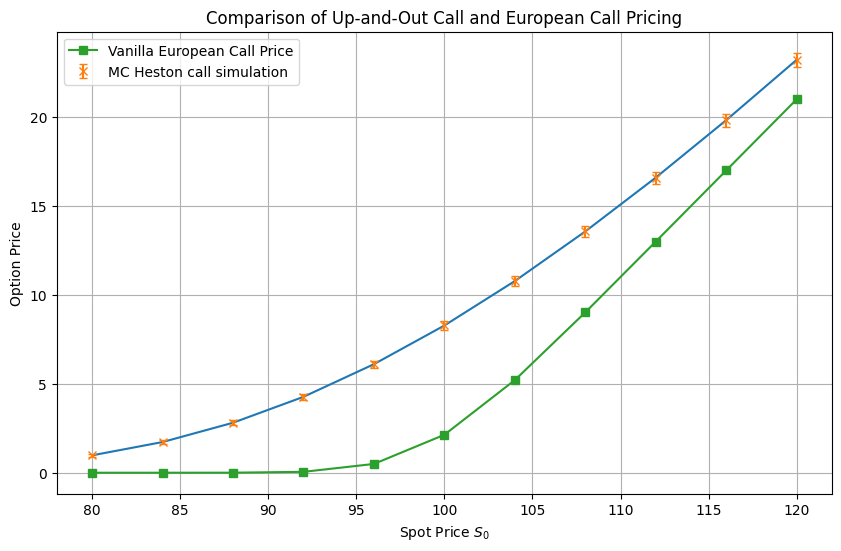

In [138]:
r = 0.01
T = 1.0

N = 1000
dt = T/N

S0_list = np.linspace(80, 120, 11)
K = 100
v0 = 0.04
lambd = 2.0
v_ = 0.04
eta = 0.2
rho = -0.5

num_steps = 100
num_simulations = 10000

lower, upper, mean = [], [], []
bs = []

for S0 in S0_list:
    
    mean_value, lower_value, upper_value = heston_call(S0, K, T, r, v0, lambd, v_, eta, rho, num_steps, num_simulations, True)
    lower.append(lower_value)
    upper.append(upper_value)
    mean.append(mean_value)
    
    bs.append(black_scholes_call(S0, K, T, r, v_))
    

plt.figure(figsize=(10, 6))
plt.plot(S0_list, mean)
plt.errorbar(S0_list, mean, yerr=[np.array(mean) - np.array(lower),
                                             np.array(upper) - np.array(mean)], 
             fmt='x', label='MC Heston call simulation ', capsize=3)

# European call price
plt.plot(S0_list, bs, label='Vanilla European Call Price', marker='s')

plt.title('Comparison of Up-and-Out Call and European Call Pricing')
plt.xlabel('Spot Price $S_0$')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()

plt.show()


Honestly, i dont know why they are so different. I dont know why the heston model is expensier. It means it caputres more the volatility? the model is more volatile? 
I will graph it and see how it behaves

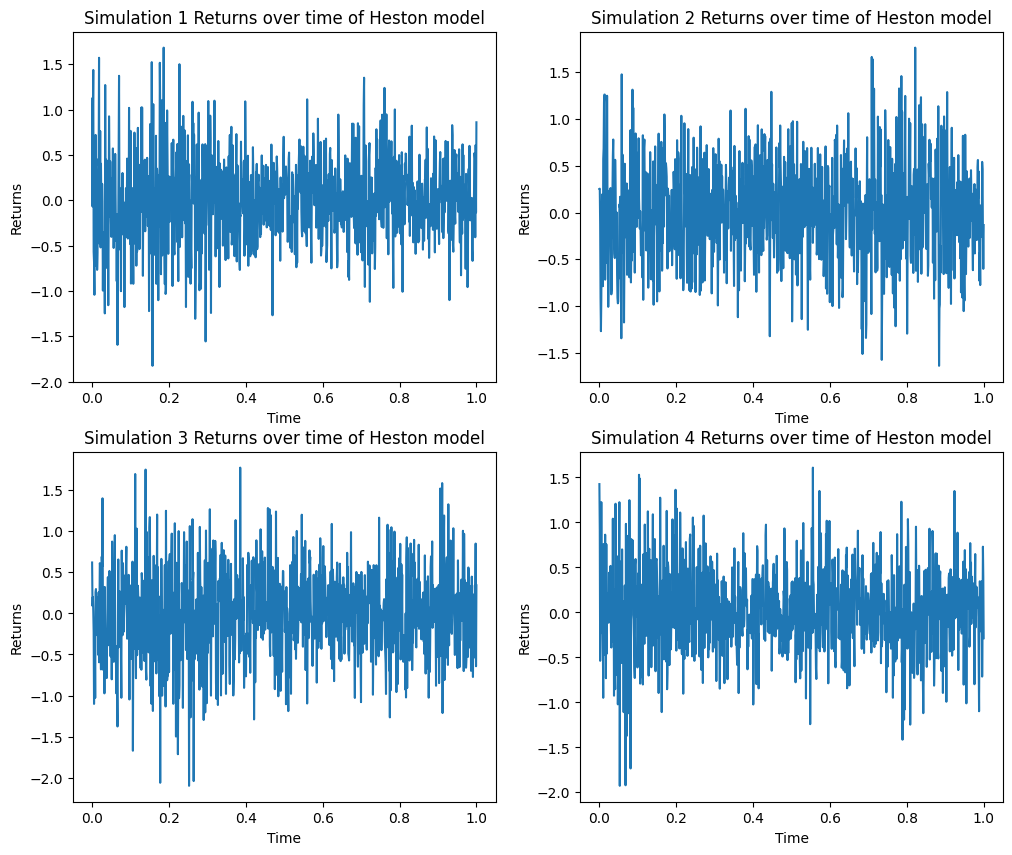

In [139]:
r = 0.01
T = 1.0

N = 1000
dt = T/N

S0 = 100
v0 = 0.04
lambd = 2.0
v_ = 0.04
eta = 0.2
rho = -0.5

num_steps = 1000
num_simulations = 4

path = heston_simulation(S0, T, r, v0, lambd, v_, eta, rho, num_steps, num_simulations)
path = path.T

returns = path[: , 1:] - path[:, :-1]
X_range = np.linspace(0, T, num_steps)

plt.figure(figsize=(12, 10))
for i in range(num_simulations):
    plt.subplot(2, 2, i + 1)
    plt.plot(X_range, returns[i, :]) 
    plt.ylabel("Returns")
    plt.xlabel("Time")
    plt.title(f"Simulation {i + 1} Returns over time of Heston model")


We can see from the graphs of the returns that the model simulates a variable volatility time serie, which is more realistic.

# 3. Implémenter le calcul de la la volatilité implicite de Black & Scholes par dichotomie. On peut se ramener à un intervalle borné en écrivant Vt = x / (1-x), x ∈ [0, 1].

In [140]:
def implied_volatility(option_price, S, K, T, r, tol=1e-6, max_iter=1000):
    lower_volatility = 0.
    upper_volatility = 1.0

    iteration = 0
    while iteration < max_iter:
        mid_volatility = (lower_volatility + upper_volatility) / 2
        option_price_mid = black_scholes_call(S, K, T, r, mid_volatility)

        if np.abs(option_price_mid - option_price) < tol:
            return mid_volatility

        if option_price_mid < option_price:
            lower_volatility = mid_volatility
        else:
            upper_volatility = mid_volatility

        iteration += 1
    return mid_volatility

In [151]:
np.random.seed(42)
S0 = 100
K = 100
T = 1
r = 0.01
option_price = 10

implied_vol = implied_volatility(option_price, S0, K, T, r)
print("Implied Volatility:", implied_vol)

Implied Volatility: 0.239749014377594


# 4. Tracer un exemple de smile de volatilité dans le modèle de Heston.

In [154]:
strikes = np.arange(50, 151, 5)
heston_prices = np.zeros(len(strikes))
implied_vols = np.zeros(len(strikes))

S0 = 100
T = 1
v0 = 0.04
lambd = 2.0
v_ = 0.04
eta = 0.2
rho = -0.5
r = 0.01
n_steps = 100
n_simulations = 1000

for i, strike in enumerate(strikes):
  heston_prices[i] = heston_call(S0, strike, T, r, v0, lambd, v_, eta, rho, n_steps, n_simulations, IC = False)
  implied_vols[i] = implied_volatility(heston_prices[i], S0, strike, T, r)

Text(0, 0.5, 'Volatilité implicite')

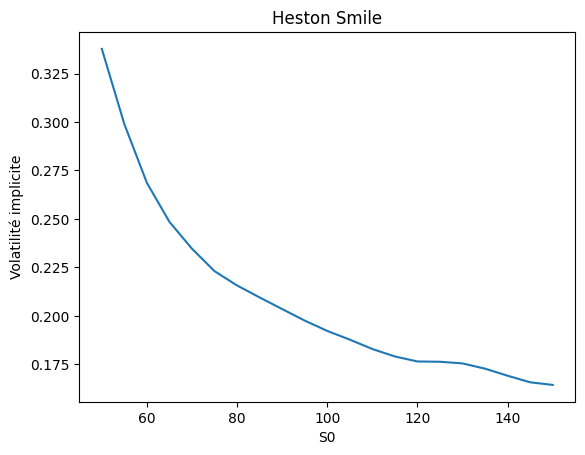

In [155]:
plt.plot(strikes, implied_vols)
plt.title("Heston Smile")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")

# 5. Montrer la déformation du smile/skew de volatilité en fonction des paramètres de la dynamique de volatilité λ, η et ρ.

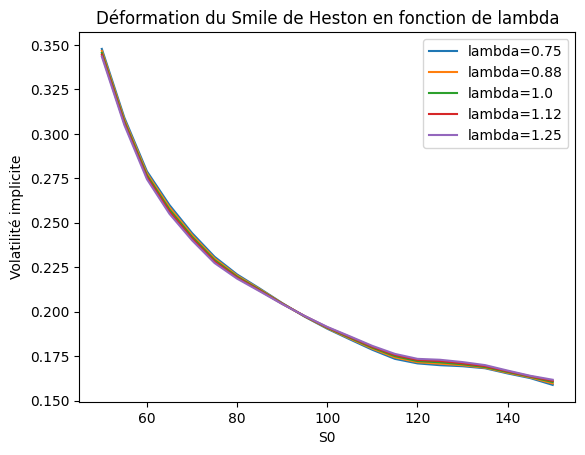

In [162]:
np.random.seed(42)
lambd_values = np.linspace(0.75, 1.25, 5)
strikes = np.arange(50, 151, 5)

S0 = 100
T = 1
v0 = 0.04
v_ = 0.04
eta = 0.2
rho = -0.5
r = 0.01
n_steps = 100
n_simulations = 1000

for lambd_ in lambd_values:
    vol_values = np.zeros(len(strikes))
    for i, strike in enumerate(strikes):
        heston_price = heston_call(S0, strike, T, r, v0, lambd_, v_, eta, rho, n_steps, n_simulations, IC=False)
        vol_values[i] = implied_volatility(heston_price, S0, strike, T, r, tol=1e-6, max_iter=1000)
    plt.plot(strikes, vol_values, label=f"lambda={np.round(lambd_,2)}")
plt.title("Déformation du Smile de Heston en fonction de lambda")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")
plt.legend()

La valeur de lambda semble impacter la convexité du smile de volatilité dans le modèle de Heston. Cela est tout à fait cohérent car le lambda représente la vitesse de retour à la moyenne du processus de variance.

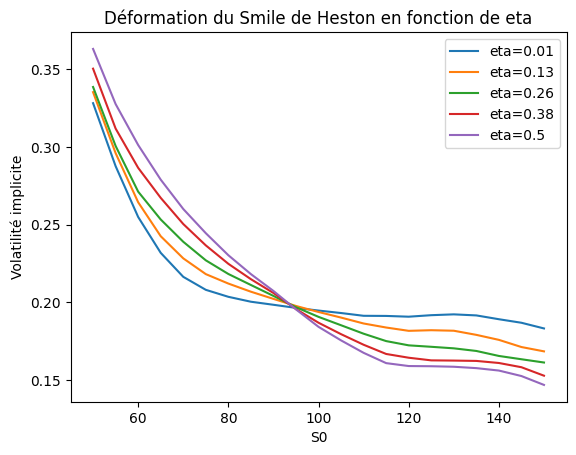

In [163]:
np.random.seed(42)
eta_values = np.linspace(0.01, 0.5, 5)
strikes = np.arange(50, 151, 5)

S0 = 100
T = 1
v0 = 0.04
lambd = 2.0
v_ = 0.04
rho = -0.5
r = 0.01
n_steps = 100
n_simulations = 1000

for eta_ in eta_values:
  vol_values = np.zeros(len(strikes))
  for i, strike in enumerate(strikes):
    heston_price = heston_call(S0, strike, T, r, v0, lambd, v_, eta_, rho, n_steps, n_simulations)
    vol_values[i] = implied_volatility(heston_price, S0, strike, T, r, tol=1e-6, max_iter=1000)
  plt.plot(strikes, vol_values, label=f"eta={round(eta_,2)}")
plt.title("Déformation du Smile de Heston en fonction de eta")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")
plt.legend()

La valeur de eta semble jouer un rôle sur la convexité mais plus spécifiquement sur la remontée skew. Avec un eta faible, cela ne permet pas la volailité implicte du modèle de Heston de remonter pour des strikes élevés.

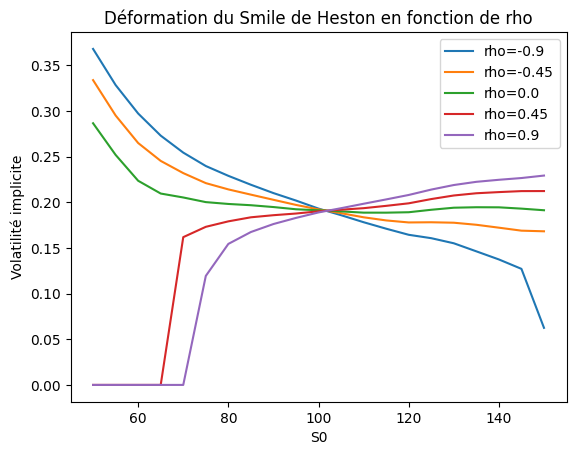

In [165]:
np.random.seed(42)
rho_values = np.linspace(-0.9, 0.9, 5)
strikes = np.arange(50, 151, 5)

S0 = 100
T = 1
v0 = 0.04
lambd = 2.0
v_ = 0.04
eta = 0.2
r = 0.01
n_steps = 100
n_simulations = 1000

for rho_ in rho_values:
  vol_values = np.zeros(len(strikes))
  for i, strike in enumerate(strikes):
    heston_price = heston_call(S0, strike, T, r, v0, lambd, v_, eta, rho_, n_steps, n_simulations)
    vol_values[i] = implied_volatility(heston_price, S0, strike, T, r, tol=1e-6, max_iter=1000)
  plt.plot(strikes, vol_values, label=f"rho={round(rho_,2)}")
plt.title("Déformation du Smile de Heston en fonction de rho")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")
plt.legend()

Rho étant le coefficient de corrélation entre les browniens associés aux deux processus, nous nous attendons à le voir jouer un rôle important sur le smile de Heston. En effet, nous remarquons qu'une corrélation très négative entraîne la formation d'un skew. Avec une corrélation nulle, il y a un faible smile centré en S0. Pour les corrélations positives, nous observons un important smile se former avec un minimum se trouvant pour une valeur inférieure à S0.